In [1]:
################################################################################
# IMPORT LIBRARIES
################################################################################

import os
import sys
import pygad
#import yaml, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%config InlineBackend.figure_format='retina' # very useful command for high-res images
%matplotlib inline

seed=42
np.random.seed(seed)

# set the username for the path of the files:
user='LB'
#user='AF'
#user='bach'
if user=='bach':
    # library paths
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/statistical_test')
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/lc_pulse_avalanche')
    # real data
    batse_path = '/astrodata/guidorzi/CGRO_BATSE/'
    swift_path = '/astrodata/guidorzi/Swift_BAT/'
    sax_path   = '/astrodata/guidorzi/BeppoSAX_GRBM/'
elif user=='LB':
    # library paths
    sys.path.append('/home/lorenzo/git/lc_pulse_avalanche/statistical_test')
    sys.path.append('/home/lorenzo/git/lc_pulse_avalanche/lc_pulse_avalanche')
    # real data
    batse_path = '/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    swift_path = '/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/Swift_BAT/'
    sax_path   = '/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/BeppoSAX_GRBM/'
elif user=='AF':
    # libraries
    sys.path.append('......WRITE_HERE....../lc_pulse_avalanche/statistical_test')
    sys.path.append('......WRITE_HERE....../lc_pulse_avalanche/lc_pulse_avalanche')
    # real data
    batse_path = 'E:/grb_to_test/CGRO_BATSE/'
    swift_path = 'E:/grb_to_test/Swift_BAT/'
    sax_path   = 'E:/grb_to_test/BeppoSAX_GRBM/'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

from statistical_test import *
from avalanche import LC, Restored_LC

In [2]:
################################################################################
# SET PARAMETERS
################################################################################

# choose the instrument
instrument = 'batse'
#instrument = 'swift'
#instrument = 'sax'

#------------------------------------------------------------------------------#

if instrument=='batse':
    t_i           = 0     # [s]
    t_f           = 150   # [s]
    eff_area      = 3600  # effective area of instrument [cm2]
    bg_level      = 10.67 # background level [cnt/cm2/s]
    t90_threshold = 2     # [s] --> used to select only _long_ GRBs
    sn_threshold  = 70    # signal-to-noise ratio
    bin_time      = 0.064 # [s] temporal bins for BATSE (its time resolution)
    test_times    = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time))
elif instrument=='swift':
    t_i           = 0                # [s]
    t_f           = 150              # [s]
    eff_area      = 1400             # effective area of instrument [cm2]
    bg_level      = (10000/eff_area) # background level [cnt/cm2/s]
    t90_threshold = 2                # [s] --> used to select only _long_ GRBs
    sn_threshold  = 20               # signal-to-noise ratio
    bin_time      = 0.064            # [s] temporal bins for Swift (its time resolution)
    test_times    = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time))
elif instrument=='sax':
    t_i           = 0               # [s]
    #t_f          = 150             # [s]
    t_f           = 50              # [s] (HR)
    eff_area      = 420             # effective area of instrument [cm2]
    bg_level      = (1000/eff_area) # background level [cnt/cm2/s]
    t90_threshold = 2               # [s] --> used to select only _long_ GRBs
    sn_threshold  = 10              # signal-to-noise ratio
    #bin_time     = 1.0             # [s] temporal bins for BeppoSAX
    bin_time      = 0.0078125       # [s] temporal bins for BeppoSAX (HR)
    test_times    = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time))
else:
    raise NameError('Variable "instrument" not defined properly; choose between: "batse", "swift", "sax".')

#------------------------------------------------------------------------------#

# The values of the 7 parameters from the paper [Stern & Svensson, 1996] are
# mu=1.2
# mu0=1
# alpha=4
# delta1=-0.5
# delta2=0
# tau_min=0.02
# tau_max=26

# We impose constraints on the range of values that the 7 parameter can assume
range_mu      = {"low": 0.6,            "high": 1.4}
range_mu0     = {"low": 0.6,            "high": 1.4} 
range_alpha   = {"low": 1,               "high": 10} 
range_delta1  = {"low": -1.5,            "high": -0.25-1.e-6} 
range_delta2  = {"low": 0.0,             "high": 0.25} 
range_tau_min = {"low": np.log10(1.e-6), "high": np.log10(bin_time-1.e-6)} # sample uniformly in log space
range_tau_max = {"low": bin_time+15,     "high": 35} 

range_constraints = [range_mu, 
                     range_mu0,
                     range_alpha,
                     range_delta1, 
                     range_delta2, 
                     range_tau_min, 
                     range_tau_max]

#------------------------------------------------------------------------------#

In [3]:
################################################################################
# LOAD REAL DATA
################################################################################

### Load the BATSE GRBs
if instrument=='batse': 
    # load all data
    grb_list_real = load_lc_batse(path=batse_path) 
    # apply constraints
    grb_list_real = apply_constraints(grb_list=grb_list_real, 
                                      bin_time=bin_time, 
                                      t90_threshold=t90_threshold, 
                                      sn_threshold=sn_threshold, 
                                      t_f=t_f)
### Load the Swift GRBs
elif instrument=='swift': 
    # load all data
    grb_list_real = load_lc_swift(path=swift_path)
    # apply constraints
    grb_list_real = apply_constraints(grb_list=grb_list_real, 
                                      bin_time=bin_time, 
                                      t90_threshold=t90_threshold, 
                                      sn_threshold=sn_threshold, 
                                      t_f=t_f)
### Load the BeppoSAX GRBs
elif instrument=='sax': 
    # load all (HR) data
    grb_list_real = load_lc_sax_hr(path=sax_path) 
    # apply constraints
    grb_list_real = apply_constraints(grb_list=grb_list_real, 
                                      bin_time=bin_time, 
                                      t90_threshold=t90_threshold, 
                                      sn_threshold=sn_threshold, 
                                      t_f=t_f)
else:
    raise NameError('Variable "instrument" not defined properly; choose between: "batse", "swift", "sax".')

100%|██████████| 1457/1457 [00:52<00:00, 27.52it/s]


Total number of _long_ GRBs in BATSE catalogue:  1457
GRBs in the catalogue which are NOT present in the data folder:  0
Loaded GRBs:  1457
Total number of input GRBs:  1457
GRBs that satisfy the constraints:  578


In [4]:
# Set the number of simulated GRBs to produce equal to the number of real GRBs
# that passed the constraint selection
N_grb=10#len(grb_list_real)

In [5]:
################################################################################
# PERFORM TESTS ON REAL DATA
################################################################################

#------------------------------------------------------------------------------#
### TEST 1&2: Average Peak-Aligned Profiles
averaged_fluxes_real, \
averaged_fluxes_cube_real, \
averaged_fluxes_rms_real = compute_average_quantities(grb_list=grb_list_real, 
                                                      t_f=t_f, 
                                                      bin_time=bin_time,
                                                      filter=True)
#------------------------------------------------------------------------------#
## TEST 3: Autocorrelation
N_lim = np.min( [N_grb, len(grb_list_real)] ) # N_grb is set equal to len(grb_list_real)
steps_real, acf_real = compute_autocorrelation(grb_list=grb_list_real,
                                               N_lim=N_lim,
                                               t_max=t_f,
                                               bin_time=bin_time,
                                               mode='scipy')
#------------------------------------------------------------------------------#
### TEST 4: Duration
#duration_real = [ evaluateDuration20(times=grb.times, 
#                                     counts=grb.counts,
#                                     filter=True,
#                                     t90=grb.t90,
#                                     bin_time=bin_time_batse)[0] for grb in grb_list_real ]
#------------------------------------------------------------------------------#

In [6]:
loss_list = []
#file = open("./sample.txt", "w")
def fitness_func(solution, solution_idx=None):
    global loss_list
    #--------------------------------------------------------------------------#
    # Generate the GRBs
    #--------------------------------------------------------------------------#
    grb_list_sim = generate_GRBs(# number of simulated GRBs to produce
                                 N_grb=N_grb,
                                 # 7 parameters
                                 mu=solution[0],
                                 mu0=solution[1],
                                 alpha=solution[2],
                                 delta1=solution[3],
                                 delta2=solution[4],
                                 tau_min=10**solution[5],  # sample uniformly in log space
                                 tau_max=solution[6],
                                 # instrument parameters
                                 instrument=instrument,
                                 bin_time=bin_time,
                                 eff_area=eff_area,
                                 bg_level=bg_level,
                                 # constraint parameters
                                 t90_threshold=t90_threshold,
                                 sn_threshold=sn_threshold,
                                 t_f=t_f,
                                 # other parameters
                                 export_files=False,
                                 n_cut=2000,
                                 with_bg=False)

    #--------------------------------------------------------------------------#
    # Compute quantities needed for the loss function
    #--------------------------------------------------------------------------#
    # TEST 1&2: Average Peak-Aligned Profiles
    averaged_fluxes_sim, \
    averaged_fluxes_cube_sim, \
    averaged_fluxes_rms_sim = compute_average_quantities(grb_list=grb_list_sim,
                                                         t_f=t_f,
                                                         bin_time=bin_time,
                                                         filter=True)
    # TEST 3: Autocorrelation
    steps_sim, acf_sim      = compute_autocorrelation(grb_list=grb_list_sim,
                                                      N_lim=N_lim,
                                                      t_max=t_f,
                                                      bin_time=bin_time,
                                                      mode='scipy')
    # TEST 4: Duration
    #--------------------------------------------------------------------------#
    # Compute loss
    #--------------------------------------------------------------------------#
    l2_loss = compute_loss(averaged_fluxes=averaged_fluxes_real,
                           averaged_fluxes_sim=averaged_fluxes_sim,
                           averaged_fluxes_cube=averaged_fluxes_cube_real, 
                           averaged_fluxes_cube_sim=averaged_fluxes_cube_sim,
                           acf=acf_real, 
                           acf_sim=acf_sim,
                           log=False, verbose=True)
    #print('l2_loss =', l2_loss)
    loss_list.append(l2_loss)
    # Saving the loss in a text file
    #content = str(l2_loss)
    #file.write(content)
    #file.write('\n')
    fitness = 1.0 / (l2_loss + 1.e-9)
    return fitness

#------------------------------------------------------------------------------#

last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    print("Generation   = {generation}".format(generation=ga_instance.generations_completed))
    print("Best Fitness = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    #print("Change      = {change}".format(change=ga_GRB.best_solution(pop_fitness=ga_GRB.last_generation_fitness)[1] - last_fitness))
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

In [7]:
num_generations    = 5  # Number of generations.
num_parents_mating = 6  # Number of solutions to be selected as parents in the mating pool.
sol_per_pop        = 10 # Number of solutions in the population.

num_genes = len(range_constraints) # 7

ga_GRB = pygad.GA(num_generations=num_generations,
                  num_parents_mating=num_parents_mating,
                  sol_per_pop=sol_per_pop,
                  num_genes=num_genes,
                  gene_type=float,
                  initial_population=None,       # if 'None', the initial population is randomly chosen using the 'sol_per_pop; and 'num_genes' parameters
                  on_generation=on_generation,
                  ### fitness function:
                  fitness_func=fitness_func,
                  ### parent selection:
                  parent_selection_type="sss",         # select the best individuals in the current generation as parents for producing the offspring of the next generation
                  keep_parents=0,                      # keep NO parents (the ones selected for mating in the current population) in the next population
                  keep_elitism=0, #int(sol_per_pop*0.05),  # keep in the next generation the best N solution of the current generation
                  ### crossover:
                  crossover_probability=0.5,     # 'None' means couples parent k with parent k+1, otherwise it selects from the parents candidate list each one of them with probability 'crossover_probability', and then it takes two of them at random
                  crossover_type="scattered",
                  ### mutation:
                  mutation_type="random",
                  mutation_probability=0.01,     # by default is 'None', otherwise it selects a value randomly from the current gene's space (each gene is changed with probability 'mutation_probability')
                  ### set range of parameters:
                  gene_space=range_constraints,
                  ### other stuff:
                  save_best_solutions=True,
                  parallel_processing=None, #["thread", 12], # =None,
                  random_seed=seed)

ga_GRB.summary()

----------------------------------------------------------------------
                           PyGAD Lifecycle                           
Step                   Handler                             Output Shape
Fitness Function       fitness_func()                      (1)      
----------------------------------------------------------------------
Parent Selection       steady_state_selection()            (6, 7)   
Number of Parents: 6
----------------------------------------------------------------------
Crossover              scattered_crossover()               (6, 7)   
Crossover probability: 0.5
----------------------------------------------------------------------
Mutation               random_mutation()                   (6, 7)   
Mutation Probability: 0.01
Mutation Genes: 1
Random Mutation Range: (-1.0, 1.0)
Gene Space: [{'low': 0.6, 'high': 1.4}, {'low': 0.6, 'high': 1.4}, {'low': 1, 'high': 10}, {'low': -1.5, 'high': -0.250001}, {'low': 0.0, 'high': 0.25}, {'low': -6.0, 'hi

/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/pygad/pygad.py:669: UserWarning: The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.
  if not self.suppress_warnings: warnings.warn("The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.")
/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/pygad/pygad.py:932: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


In [8]:
# Running the GA to optimize the parameters of the function.
ga_GRB.run()
#ga_GRB.plot_fitness()
#file.close()

Generation   = 1
Best Fitness = 0.5542412844893403
Generation   = 2
Best Fitness = 0.646237560316745
Generation   = 3
Best Fitness = 0.5505085946521793
Generation   = 4
Best Fitness = 0.5900278062710235
Generation   = 5
Best Fitness = 0.5365532424084462


In [9]:
len(loss_list)

60

In [10]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_GRB.best_solution(ga_GRB.last_generation_fitness)
print("* Parameters of the best solution:")
print("    - mu      = {solution}".format(solution=solution[0]))
print("    - mu0     = {solution}".format(solution=solution[1]))
print("    - alpha   = {solution}".format(solution=solution[2]))
print("    - delta1  = {solution}".format(solution=solution[3]))
print("    - delta2  = {solution}".format(solution=solution[4]))
print("    - tau_min = {solution}".format(solution=10**(solution[5])))
print("    - tau_max = {solution}".format(solution=solution[6]))
print("* Loss value of the best solution    : {solution_loss}".format(solution_loss=solution_fitness**(-1)))
print("* Fitness value of the best solution : {solution_fitness}".format(solution_fitness=solution_fitness))
#print("Index of the best solution          : {solution_idx}".format(solution_idx=solution_idx))

if ga_GRB.best_solution_generation != -1:
    print("* Best fitness value reached after N={best_solution_generation} generations.".format(best_solution_generation=ga_GRB.best_solution_generation))

* Parameters of the best solution:
    - mu      = 0.8854026613548713
    - mu0     = 1.0808920093945669
    - alpha   = 7.372653200164409
    - delta1  = -1.2868450159150093
    - delta2  = 0.2237068376069122
    - tau_min = 0.03635031910442075
    - tau_max = 33.80641466239617
* Loss value of the best solution    : 1.8637479395544485
* Fitness value of the best solution : 0.5365532424084462
* Best fitness value reached after N=2 generations.


In [13]:
### PARAMETERS FROM THE PAPER:
# mu=1.2
# mu0=1
# alpha=4
# delta1=-0.5
# delta2=0
# tau_min=0.02
# tau_max=26

In [14]:
# Saving the GA instance.
# filename = 'genetic' # The filename to which the instance is saved. The name is without extension.
# ga_GRB.save(filename=filename)

# Loading the saved GA instance.
# loaded_ga_GRB = pygad.load(filename=filename)
# loaded_ga_GRB.plot_fitness()

In [11]:
# avg_loss = np.zeros(num_generations)
# std_loss = np.zeros(num_generations)
# for i in range(num_generations):
#     avg_loss[i] = np.mean(loss_list[i*sol_per_pop:(i+1)*sol_per_pop])
#     std_loss[i] = np.std( loss_list[i*sol_per_pop:(i+1)*sol_per_pop])

window_size = 5
# Convert array of integers to pandas series
loss_list = pd.Series(loss_list)
# Get the window of series
# of observations of specified window size
windows = loss_list.rolling(window_size)
# Create a series of moving
# averages of each window
moving_averages = windows.mean().tolist()
# Remove null entries from the list
loss_list = np.array(moving_averages[window_size - 1:])

inv_fit[-1] = 0.5651565080461304


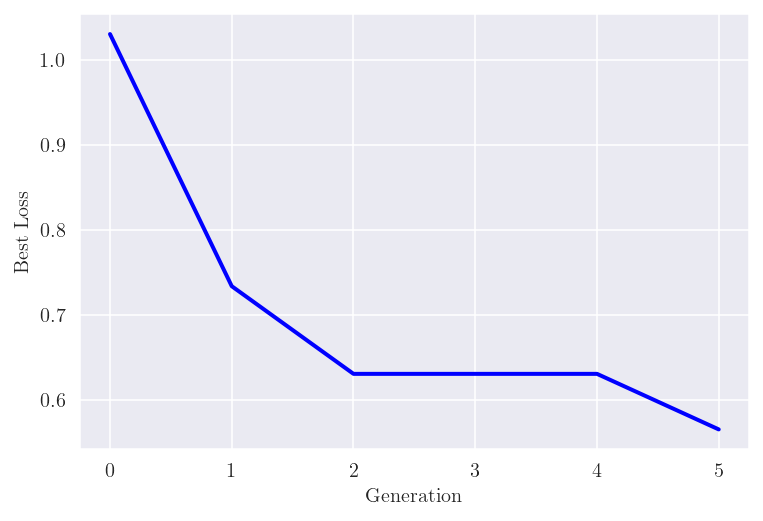

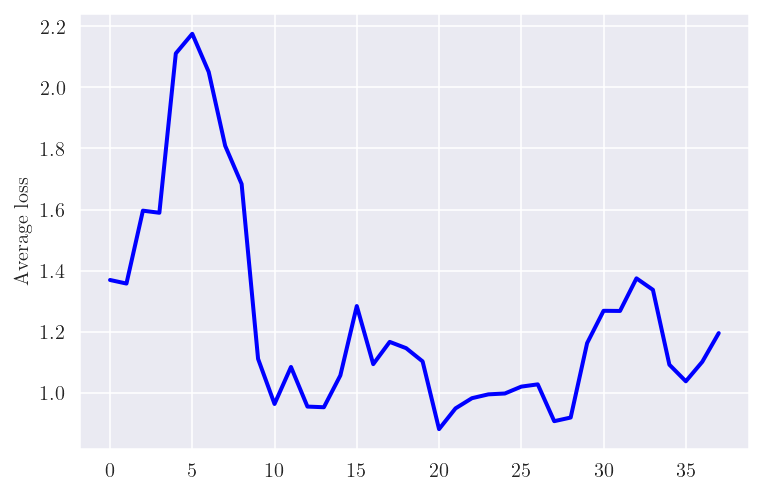

In [16]:
inv_fit = (np.array(ga_GRB.best_solutions_fitness))**(-1)
print('inv_fit[-1] =', inv_fit[-1])
plt.plot(inv_fit, ls='-', lw=2, c='b')
#plt.yscale('log')
plt.xlabel('Generation')
plt.ylabel(r'Best Loss')
plt.show()

# plt.plot(loss_list, ls='-', lw=2, c='b')
# plt.ylabel(r'Average loss') 
# plt.show()     

# plt.errorbar(np.arange(num_generations), avg_loss, yerr=std_loss/np.sqrt(sol_per_pop), ls='-', lw=2, c='b')
# #plt.yscale('log')
# plt.xlabel('Generation')
# plt.ylabel(r'Average Loss')
# plt.show()
# 
# plt.plot(std_loss, ls='-', lw=2, c='b')
# plt.xlabel('Generation')
# plt.ylabel(r'Standard Deviation of the loss')
# plt.show()

# DEBUG

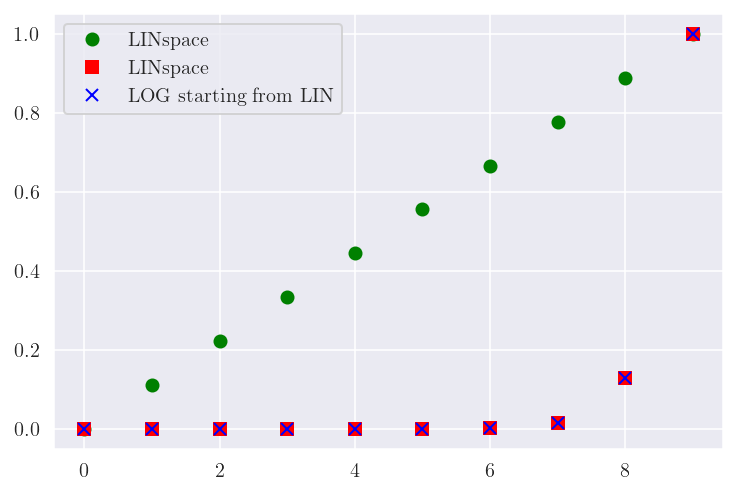

In [54]:
a = 1.e-8
b = 1
linspace  = np.linspace(         a,           b,  num=10)
logspace  = np.logspace(np.log10(a), np.log10(b), num=10)
logspace_ = np.linspace(np.log10(a), np.log10(b), num=10)

plt.plot(linspace,      'go', label='LINspace')
plt.plot(logspace,      'rs', label='LINspace')
plt.plot(10**logspace_, 'bx', label='LOG starting from LIN')
plt.legend()
plt.show()